#### This file looks to anaylze Morris County Green Space Data

In [120]:
import geopandas as gpd
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import CRS
import fiona
from tqdm import tqdm
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')


df = gpd.read_file('./Morris_Subset.gpkg', driver="GPKG")
morris_county_map = gpd.read_file("../Data/morrisCountyShapefile")
df = df.to_crs(epsg=4326) # Same coordinate system
morris_county_map = morris_county_map.to_crs(epsg=4326)

### Geo Plot w/ Morris County

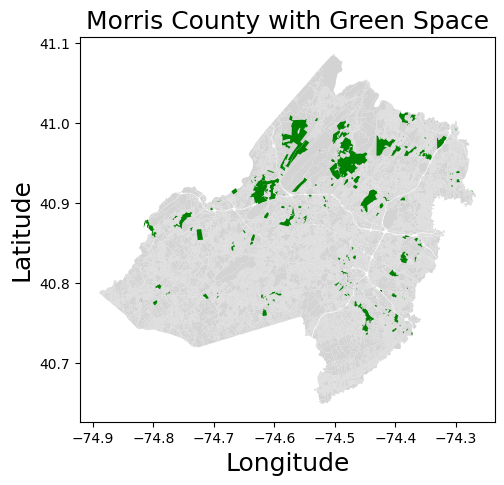

In [95]:
fig, ax = plt.subplots(figsize=(10, 5))
morris_county_map.plot(ax=ax, color='lightgrey')
df.plot(ax=ax, color='green')
plt.xlabel('Longitude', fontsize=18)
plt.ylabel('Latitude', fontsize=18)
plt.savefig('../Figures/plots/allGreenSpaceMorris.png')
ax.set_title("Morris County with Green Space", fontsize=18);

In [4]:
list(df.Park_Place.unique()) #24

['Boonton town',
 'Budd Lake CDP',
 'Butler borough',
 'Chatham borough',
 None,
 'Chester borough',
 'Dover town',
 'Florham Park borough',
 'Kenvil CDP',
 'Kinnelon borough',
 'Lake Telemark CDP',
 'Lincoln Park borough',
 'Long Valley CDP',
 'Madison borough',
 'Mendham borough',
 'Morris Plains borough',
 'Morristown town',
 'Mount Arlington borough',
 'Mountain Lakes borough',
 'Netcong borough',
 'Riverdale borough',
 'Rockaway borough',
 'Succasunna CDP',
 'Wharton borough',
 'White Meadow Lake CDP']

### Need to organize town names by NJGIN standards

In [98]:
change_dict = {'Boonton town':'Boonton Town','Budd Lake CDP':'Mount Olive Township','Butler borough':'Butler Borough','Chatham borough':'Chatham Borough','Chester borough':'Chester Borough','Dover town':'Dover Town','Florham Park borough':'Florham Park Borough','Kenvil CDP':'Roxbury Township','Kinnelon borough':'Kinnelon Borough','Lake Telemark CDP':'Rockaway Township','Lincoln Park borough':'Lincoln Park Borough','Long Valley CDP':'Washington Township','Madison borough':'Madison Borough','Mendham borough':'Mendham Borough','Morris Plains borough':'Morris Plains Borough','Morristown town':'Morristown Town','Mount Arlington borough':'Mount Arlington Borough','Mountain Lakes borough':'Mountain Lakes Borough','Netcong borough':'Netcong Borough','Riverdale borough':'Riverdale Borough','Rockaway borough':'Rockaway Borough','Succasunna CDP':'Roxbury Township','Wharton borough':'Wharton Borough','White Meadow Lake CDP':'Rockaway Township'}

24

In [177]:
df_good = df.copy()
df_good = df_good.to_crs(epsg=4326)
df_good = df_good.set_crs(epsg=4326)
df_good.replace({'Park_Place': change_dict}, inplace=True)

In [178]:
df_na = df_good[df_good.Park_Place.isna()]
df_good = df_good[df_good['Park_Place'].notna()]
len(df_na)

21

In [179]:
df_na

,ParkID,GISTrkrID,SourceID,Park_Name,Park_Designation,Park_Owner_Type,Park_Local_Owner,Park_Manager_Type,Park_Local_Manager,Park_Access,...,SUM_BLACK_SVC,SUM_AMERINDSVC,SUM_ASIAN_SVC,SUM_PACIFICSVC,SUM_OTHRACESVC,SUM_RACE2UPSVC,SUM_HISP_SVC,Shape_Length,Shape_Area,geometry
12,3412100-0003,0.0,3.0,Courgar Field,LP,CITY,Borough of Catham,CITY,Borough of Catham,3.0,...,14.0,1.0,191.0,0.0,6.0,87.0,106.0,2041.893262,1.513064e+05,"MULTIPOLYGON (((-74.39978 40.74374, -74.39924 ..."
15,3412580-0001,0.0,1.0,Chubb Park,LP,CITY,Township of Chester,CITY,Township of Chester,3.0,...,1.0,0.0,9.0,0.0,0.0,8.0,32.0,2447.799645,2.913007e+05,"MULTIPOLYGON (((-74.71823 40.78460, -74.71332 ..."
20,3418070-0003,0.0,3.0,Hedden County Park,LP,CNTY,Morris County,CNTY,Morris County,3.0,...,265.0,3.0,267.0,0.0,30.0,122.0,3559.0,6951.256760,1.250017e+06,"MULTIPOLYGON (((-74.57533 40.87186, -74.57655 ..."
69,3442510-0009,387.0,9.0,Loantaka Brook Reservation,LCA,CNTY,Morris County,CNTY,Morris County,3.0,...,115.0,3.0,441.0,2.0,27.0,188.0,385.0,22397.110817,2.332918e+06,"MULTIPOLYGON (((-74.45140 40.76780, -74.45046 ..."
107,3450130-0003,0.0,3.0,Dominick Arbolino Memorial Park,SOTH,ST,State of New Jersey,ST,State of New Jersey,3.0,...,49.0,7.0,59.0,0.0,4.0,78.0,375.0,1910.127714,3.312507e+04,"MULTIPOLYGON (((-74.68729 40.90394, -74.68751 ..."
108,63217-0168,387.0,168.0,Rockaway River,SCA,ST,NEW JERSEY DEPT OF ENVIRONMENTAL PROTECTION,ST,NEW JERSEY DEPT OF ENVIRONMENTAL PROTECTION,3.0,...,7.0,0.0,15.0,0.0,1.0,8.0,48.0,56260.541731,1.212827e+07,"MULTIPOLYGON (((-74.57034 41.00478, -74.57090 ..."
110,63217-0173,387.0,173.0,Berkshire Valley,SCA,ST,NEW JERSEY DEPT OF ENVIRONMENTAL PROTECTION,ST,NEW JERSEY DEPT OF ENVIRONMENTAL PROTECTION,3.0,...,132.0,1.0,376.0,0.0,27.0,105.0,722.0,36521.579465,7.520098e+06,"MULTIPOLYGON (((-74.61660 40.93627, -74.61577 ..."
111,63217-0176,387.0,176.0,Hopatcong State Park,SP,ST,STATE OF NEW JERSEY,ST,STATE OF NEW JERSEY,3.0,...,51.0,0.0,36.0,0.0,1.0,35.0,177.0,2522.921512,3.827788e+05,"MULTIPOLYGON (((-74.66109 40.91417, -74.66751 ..."
112,63217-0180,387.0,180.0,Rockaway River,SCA,ST,NEW JERSEY DEPT OF ENVIRONMENTAL PROTECTION,ST,NEW JERSEY DEPT OF ENVIRONMENTAL PROTECTION,3.0,...,27.0,1.0,156.0,0.0,5.0,31.0,95.0,608.103160,1.001338e+04,"MULTIPOLYGON (((-74.38815 40.89951, -74.38787 ..."
113,63217-0181,387.0,181.0,Stephens State Park,SP,ST,STATE OF NEW JERSEY,ST,STATE OF NEW JERSEY,3.0,...,56.0,0.0,114.0,0.0,3.0,37.0,160.0,12797.280017,1.139939e+06,"MULTIPOLYGON (((-74.80587 40.87304, -74.80577 ..."


### We have 21 green spaces without a neighborhood identifier, considering that our dataset is so small <200, we should try our best to find the town, we will use the geospatial geometry to identify the town.

In [180]:
filename = "../Data/morrisMunicipalities/Municipalities.shp"
gdf = gpd.read_file(filename).reset_index(drop=True)
gdf = gdf.to_crs(4326) # Change coordinate systems

In [181]:
new_town_list = []
for row in tqdm(range(len(df_na))):
    row_green = df_na.iloc[[row]]
    row_green_geom = row_green.geometry
    
    town_var = None
    for index in range(len(gdf)):
        gdf_row = gdf.iloc[[index]]
        #print(gdf_row)
        town = gdf_row.Label.values[0] 
        
        aoi_geom = gdf_row.unary_union
        
        #if aoi_geom.contains(row_green_geom).all():
        #    town_var = town
        #    break
        
        # method 2
        threshold = 0.75
        polygon_intersection = aoi_geom.intersection(row_green_geom).area
        area = (polygon_intersection / row_green_geom.area).all()
        if area > threshold:
            town_var = town
            break

    new_town_list.append(town_var)

df_na.Park_Place = new_town_list

100%|██████████| 21/21 [00:03<00:00,  6.89it/s]


In [196]:
df_comb = pd.concat([df_good, df_na], ignore_index=True)

In [197]:
df_comb.drop(["Shape_Length","Shape_Area","geometry"], axis=1, inplace=True) # No longer need geometry

In [198]:
df_comb

,ParkID,GISTrkrID,SourceID,Park_Name,Park_Designation,Park_Owner_Type,Park_Local_Owner,Park_Manager_Type,Park_Local_Manager,Park_Access,...,SUM_HHIHIGHSVCA,SUM_TOTHHSVCA,SUM_WHITE_SVC,SUM_BLACK_SVC,SUM_AMERINDSVC,SUM_ASIAN_SVC,SUM_PACIFICSVC,SUM_OTHRACESVC,SUM_RACE2UPSVC,SUM_HISP_SVC
0,3406610-0001,0.0,1.0,Kanouse Pocket Park,LP,CITY,Town of Boonton,CITY,Town of Boonton,3.0,...,256.0,463.0,791.0,42.0,1.0,124.0,0.0,3.0,43.0,179.0
1,3406610-0002,0.0,2.0,Grace Lord Park,LP,CITY,Town of Boonton,CITY,Town of Boonton,3.0,...,859.0,1710.0,2739.0,249.0,1.0,489.0,0.0,22.0,193.0,723.0
2,3406610-0003,0.0,3.0,Pepe Field,LP,CITY,Town of Boonton,CITY,Town of Boonton,3.0,...,482.0,1124.0,1712.0,178.0,0.0,382.0,0.0,16.0,129.0,499.0
3,3406610-0004,0.0,4.0,Veterans Memorial Park,LP,CITY,Town of Boonton,CITY,Town of Boonton,3.0,...,294.0,467.0,981.0,38.0,1.0,135.0,0.0,6.0,42.0,142.0
4,3408620-0001,0.0,1.0,Camelot Park,LP,CITY,Mount Olive Township,CITY,Mount Olive Township,3.0,...,119.0,227.0,528.0,28.0,0.0,43.0,0.0,2.0,23.0,97.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,63217-0499,NaN,NaN,Oak Meadows,LP,CITY,Rockaway Township,CITY,Rockaway Township,3.0,...,70.0,107.0,245.0,2.0,0.0,12.0,0.0,0.0,11.0,16.0
160,63217-0500,NaN,NaN,Egbert Lake Park,LP,CITY,Rockaway Township,CITY,Rockaway Township,3.0,...,28.0,45.0,95.0,2.0,0.0,5.0,0.0,0.0,4.0,11.0
161,63217-0501,NaN,NaN,Germania Park,LP,CITY,Rockaway Township,CITY,Rockaway Township,3.0,...,405.0,810.0,953.0,86.0,1.0,153.0,0.0,9.0,40.0,1199.0
162,63217-0657,5555.0,111.0,Lillis Estate,RECE,NGO,Township of Washington,JOINT,Township of Washington,3.0,...,48.0,58.0,146.0,1.0,0.0,5.0,0.0,1.0,6.0,13.0


### Basic Exploration

In [204]:
# Look at how many parks per town
df_comb.Park_Place.value_counts()

Park_Place
Morristown Town                   20
Kinnelon Borough                  16
Rockaway Township                 14
Lincoln Park Borough              10
Madison Borough                   10
Morris Plains Borough              9
Dover Town                         9
Roxbury Township                   8
Mendham Borough                    8
Rockaway Borough                   6
Mount Olive Township               6
Wharton Borough                    5
Mount Arlington Borough            5
Washington Township                5
Mountain Lakes Borough             4
Boonton Town                       4
Florham Park Borough               4
Chatham Borough                    4
Netcong Borough                    3
Butler Borough                     3
Chester Borough                    2
Chatham Township                   2
Parsippany-Troy Hills Township     2
Riverdale Borough                  1
Chester Township                   1
Jefferson Township                 1
Hanover Township           

In [205]:
df_comb.groupby('Park_Place')["SUM_TOTPOPSVCA"].sum() # Total population per town within a 10-minute walk of green space

Park_Place
Boonton Town                       9888.0
Butler Borough                     5785.0
Chatham Borough                    9285.0
Chatham Township                   7053.0
Chester Borough                    1152.0
Chester Township                    227.0
Dover Town                        39030.0
Florham Park Borough               3745.0
Hanover Township                     41.0
Jefferson Township                  304.0
Kinnelon Borough                   4906.0
Lincoln Park Borough               9372.0
Madison Borough                   26298.0
Mendham Borough                    4196.0
Morris Plains Borough             11845.0
Morristown Town                   64804.0
Mount Arlington Borough            8606.0
Mount Olive Township               7348.0
Mountain Lakes Borough             7098.0
Netcong Borough                    3917.0
Parsippany-Troy Hills Township     3869.0
Pequannock Township                 400.0
Riverdale Borough                  1342.0
Rockaway Borough       

In [206]:
df_comb.groupby('Park_Place')["SUM_BLACK_SVC"].sum().sort_values(ascending=False)

Park_Place
Morristown Town                   6022.0
Dover Town                        1582.0
Madison Borough                    682.0
Boonton Town                       507.0
Morris Plains Borough              378.0
Wharton Borough                    346.0
Rockaway Township                  300.0
Mount Olive Township               289.0
Rockaway Borough                   277.0
Mount Arlington Borough            235.0
Roxbury Township                   168.0
Netcong Borough                    141.0
Lincoln Park Borough               135.0
Chatham Township                   129.0
Mountain Lakes Borough              94.0
Butler Borough                      92.0
Chatham Borough                     86.0
Kinnelon Borough                    55.0
Parsippany-Troy Hills Township      54.0
Florham Park Borough                54.0
Riverdale Borough                   33.0
Mendham Borough                     29.0
Washington Township                  9.0
Jefferson Township                   7.0
Pequa

In [207]:
df_comb.groupby('Park_Place')["SUM_WHITE_SVC"].sum().sort_values(ascending=False)
# Total white population per town within a 10-minute walk of green space

Park_Place
Morristown Town                   28620.0
Madison Borough                   18444.0
Morris Plains Borough              8752.0
Rockaway Township                  8701.0
Dover Town                         7555.0
Chatham Borough                    7216.0
Lincoln Park Borough               7061.0
Rockaway Borough                   6442.0
Mount Arlington Borough            6267.0
Boonton Town                       6223.0
Chatham Township                   5474.0
Roxbury Township                   5266.0
Mountain Lakes Borough             5118.0
Mount Olive Township               4944.0
Butler Borough                     4029.0
Kinnelon Borough                   3926.0
Wharton Borough                    3761.0
Mendham Borough                    3607.0
Florham Park Borough               3093.0
Parsippany-Troy Hills Township     2534.0
Netcong Borough                    2504.0
Washington Township                1119.0
Riverdale Borough                  1035.0
Chester Borough        

In [208]:
df_comb.groupby('Park_Place')["SUM_HISP_SVC"].sum().sort_values(ascending=False)

Park_Place
Dover Town                        27910.0
Morristown Town                   24701.0
Wharton Borough                    5289.0
Madison Borough                    4021.0
Rockaway Township                  2277.0
Rockaway Borough                   1961.0
Boonton Town                       1543.0
Morris Plains Borough              1476.0
Mount Arlington Borough            1280.0
Lincoln Park Borough               1279.0
Butler Borough                     1246.0
Mount Olive Township               1077.0
Roxbury Township                    985.0
Netcong Borough                     940.0
Chatham Borough                     641.0
Mountain Lakes Borough              500.0
Chatham Township                    491.0
Kinnelon Borough                    425.0
Parsippany-Troy Hills Township      315.0
Mendham Borough                     248.0
Chester Borough                     197.0
Florham Park Borough                193.0
Riverdale Borough                   183.0
Washington Township    

In [267]:
# Percent of total population
new_df = pd.DataFrame()
new_df["town"] = df_comb.Park_Place.sort_values(ascending=True).unique()
town_pop = df_comb.groupby('Park_Place')["SUM_TOTPOPSVCA"].sum()
grouping_vars = ['SUM_BLACK_SVC','SUM_WHITE_SVC','SUM_HISP_SVC','SUM_HHILOWSVCA','SUM_HHIMEDSVCA','SUM_HHIHIGHSVCA']

for var in grouping_vars:
    new_col = df_comb.groupby('Park_Place')[var].sum()/town_pop
    new_col = new_col.values
    new_df[var] = new_col
new_df['Park_Size_Acres'] = df_comb.groupby('Park_Place')["Park_Size_Acres"].sum().values

In [270]:
new_df.to_csv('./green_space_estimates.csv', index=False)